# Hurricane Data to SQL database


load necessary packages

In [1]:
import sqlite3
import pandas as pd
import geopandas as gpd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import sys
import numpy as np
sys.path.append('..')
from functions import *

load necessary dataset

## Hurricane Risk Score Index

In [2]:
#Load the shapefile
shapefile_path = "../../shapefile/NRI_Shapefile_Counties/NRI_Shapefile_Counties.shp"
print('loading')
gdf = gpd.read_file(shapefile_path)
print('loaded')
#Filter the data to exclude Alaska and the islands
mainland_usa_gdf = gdf[
    (gdf['STATE'] != 'Alaska') & 
    (gdf['STATE'] != 'Hawaii') & 
    (gdf['STATE'] != 'Puerto Rico') & 
    (gdf['STATE'] != 'Guam') & 
    (gdf['STATE'] != 'American Samoa') & 
    (gdf['STATE'] != 'Northern Mariana Islands') & 
    (gdf['STATE'] != 'Virgin Islands')
].copy()

#mainland_usa_gdf.loc[:, 'HRCN_RISKS'].replace(-9999, np.nan, inplace=True)
mainland_usa_gdf = mainland_usa_gdf[mainland_usa_gdf['HRCN_RISKS'] != -9999]
#Takes around 5 mins to run

loading
loaded


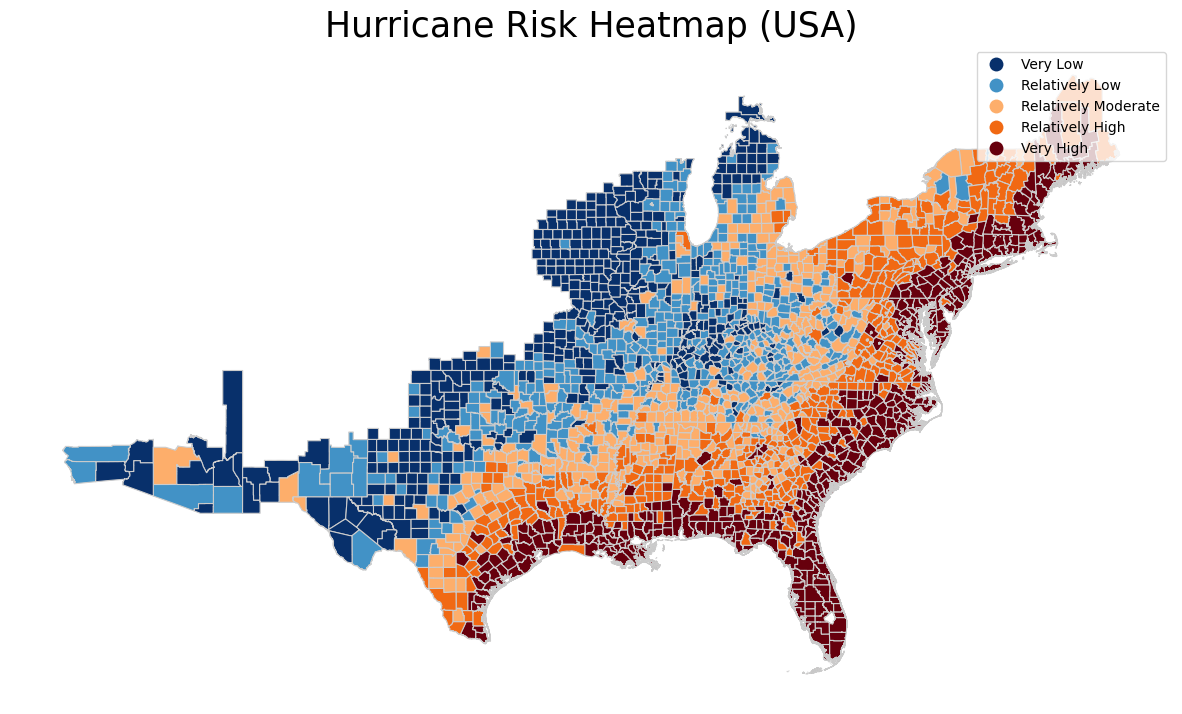

In [3]:
#5 bins based on quantiles to categorize the scores into 5 distinct sections
mainland_usa_gdf['HRCN_EALS_Norm'] = (mainland_usa_gdf['HRCN_EALS'] - mainland_usa_gdf['HRCN_EALS'].mean())/ mainland_usa_gdf['HRCN_EALS'].std()
mainland_usa_gdf['HRCN_RISK_CATEGORY_QUANTILE'] = pd.qcut(mainland_usa_gdf['HRCN_EALS_Norm'], q=5, labels=['Very Low', "Relatively Low", 'Relatively Moderate', 'Relatively High', 'Very High'])
colors = ['#08306b', '#4292c6', '#fdae6b', '#f16913', '#67000d']
custom_cmap = ListedColormap(colors) # type: ignore
#Plot the heatmap
fig, ax = plt.subplots(1, 1, figsize=(15, 25))
plt.grid(False)
mainland_usa_gdf.plot(column='HRCN_RISK_CATEGORY_QUANTILE', cmap=custom_cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Hurricane Risk Heatmap (USA)', fontdict={'fontsize': '25', 'fontweight' : '3'})
#Remove all axis values
ax.set_xticks([])
ax.set_yticks([])
#Remove all axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# Display the map
#Save plot heatmap
plt.savefig('../../Plots/hurricane_risk_heatmap.png')
plt.show()

## Subset data to HRCN to MSA

In [4]:
mainland_usa_gdf_msa = mainland_usa_gdf.copy()
#load cbsa_to_fips xlsx file
cbsa_to_fips_df = pd.read_excel('../../Data/cbsa_to_fips.xlsx', dtype={'MSA': str, 'STCOFIPS': str, 'statename': str})
display(cbsa_to_fips_df)
cbsa_to_fips_df = cbsa_to_fips_df[['MSA', 'STCOFIPS', 'statename']]
#create new column in mainland_usa_gdf called MSA looking up in cbsa_to_fips_df
mainland_usa_gdf_msa.loc[:, 'MSA'] = mainland_usa_gdf_msa['STCOFIPS'].map(cbsa_to_fips_df.set_index('STCOFIPS')['MSA'])
#extract stcofips where msa is na
stcofips_na = mainland_usa_gdf_msa[mainland_usa_gdf_msa['MSA'].isna()]['STCOFIPS']
#remove na
mainland_usa_gdf_msa = mainland_usa_gdf_msa[~mainland_usa_gdf_msa['MSA'].isna()]



,MSA,STCOFIPS,metropolitandivisioncode,csacode,cbsatitle,metropolitanmicropolitanstatis,metropolitandivisiontitle,csatitle,countycountyequivalent,statename,fipsstatecode,fipscountycode,centraloutlyingcounty
0,33860,01001,NaN,388.0,"Montgomery, AL",Metropolitan Statistical Area,NaN,"Montgomery-Selma, AL",Autauga County,Alabama,1,1,Central
1,19300,01003,NaN,380.0,"Daphne-Fairhope-Foley, AL",Metropolitan Statistical Area,NaN,"Mobile-Daphne-Fairhope, AL",Baldwin County,Alabama,1,3,Central
2,21640,01005,NaN,NaN,"Eufaula, AL-GA",Micropolitan Statistical Area,NaN,NaN,Barbour County,Alabama,1,5,Central
3,13820,01007,NaN,142.0,"Birmingham, AL",Metropolitan Statistical Area,NaN,"Birmingham-Cullman-Talladega, AL",Bibb County,Alabama,1,7,Outlying
4,13820,01009,NaN,142.0,"Birmingham, AL",Metropolitan Statistical Area,NaN,"Birmingham-Cullman-Talladega, AL",Blount County,Alabama,1,9,Outlying
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1910,41980,72143,NaN,490.0,"San Juan-Bayam√≥n-Caguas, PR",Metropolitan Statistical Area,NaN,"San Juan-Bayam√≥n, PR",Vega Alta Municipio,Puerto Rico,72,143,Central
1911,41980,72145,NaN,490.0,"San Juan-Bayam√≥n-Caguas, PR",Metropolitan Statistical Area,NaN,"San Juan-Bayam√≥n, PR",Vega Baja Municipio,Puerto Rico,72,145,Central
1912,38660,72149,NaN,434.0,"Ponce, PR",Metropolitan Statistical Area,NaN,"Ponce-Coamo, PR",Villalba Municipio,Puerto Rico,72,149,Outlying
1913,41980,72151,NaN,490.0,"San Juan-Bayam√≥n-Caguas, PR",Metropolitan Statistical Area,NaN,"San Juan-Bayam√≥n, PR",Yabucoa Municipio,Puerto Rico,72,151,Central


In [5]:
#show columns that have HRCN in mainland_usa_gdf
# display(mainland_usa_gdf.columns[mainland_usa_gdf.columns.str.contains('HRCN')])
#Save mainland_usa_gdf_HRCN file which includes HRCN columns
hrcn_columns = [col for col in mainland_usa_gdf_msa.columns if 'HRCN' in col]
selected_columns = ['MSA','geometry'] + hrcn_columns
mainland_usa_gdf_msa = mainland_usa_gdf_msa[selected_columns]
display(mainland_usa_gdf_msa)
#Save Pickle file
mainland_usa_gdf_msa.to_pickle('../../Data/mainland_usa_gdf_msa.pkl')

,MSA,geometry,HRCN_EVNTS,HRCN_AFREQ,HRCN_EXP_A,HRCN_EXPB,HRCN_EXPP,HRCN_EXPPE,HRCN_EXPA,HRCN_EXPT,...,HRCN_EALR,HRCN_ALRB,HRCN_ALRP,HRCN_ALRA,HRCN_ALR_N,HRCN_RISKV,HRCN_RISKS,HRCN_RISKR,HRCN_EALS_Norm,HRCN_RISK_CATEGORY_QUANTILE
0,33860,"POLYGON ((-9619432.840 3847073.744, -9619428.2...",13.0,0.080450,610.470508,9.121108e+09,58748.668261,6.814846e+11,2.449691e+07,6.906302e+11,...,Relatively Low,9.270623e-05,3.347524e-08,0.001901,64.677907,1.014608e+06,67.653656,Relatively Low,0.628278,Relatively High
1,19300,"MULTIPOLYGON (((-9787951.364 3588674.829, -978...",50.0,0.248233,1674.843955,4.596806e+10,231362.821627,2.683809e+12,1.380755e+08,2.729915e+12,...,Relatively High,3.778297e-03,2.357612e-06,0.011345,94.682231,1.895320e+08,98.878421,Relatively High,1.779407,Very High
2,21640,"POLYGON ((-9491049.106 3781487.459, -9490968.1...",21.0,0.116398,913.646511,4.847697e+09,25160.000000,2.918560e+11,1.210758e+08,2.968248e+11,...,Relatively Low,3.145919e-04,7.186926e-08,0.003586,78.815391,3.079796e+06,77.164648,Relatively Low,0.855454,Relatively High
3,13820,"POLYGON ((-9687669.284 3924165.445, -9687659.8...",11.0,0.066724,632.486798,3.146947e+09,22239.000000,2.579724e+11,4.819356e+06,2.611242e+11,...,Very Low,5.640757e-05,1.356953e-08,0.000507,59.446606,2.226110e+05,51.099148,Very Low,0.018408,Relatively Moderate
4,13820,"POLYGON ((-9622917.941 4063649.874, -9622939.5...",6.0,0.039238,657.196555,7.815387e+09,58989.060165,6.842731e+11,2.776569e+08,6.923661e+11,...,Very Low,2.421447e-05,4.874959e-09,0.000199,49.632512,3.010121e+05,54.015253,Very Low,0.135808,Relatively Moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3110,29100,"POLYGON ((-10053513.068 5422980.224, -10053519...",1.0,0.007114,824.625839,7.248688e+09,30561.000559,3.545076e+11,2.057475e+08,3.619620e+11,...,Very Low,4.839027e-07,1.795769e-11,0.000004,2.204929,4.974228e+03,5.069538,Very Low,-1.548958,Very Low
3112,48580,"POLYGON ((-9830236.517 5287472.816, -9830237.7...",1.0,0.005844,582.417186,2.939239e+10,106412.801613,1.234388e+12,1.898404e+08,1.263971e+12,...,Very Low,6.186311e-07,4.044175e-11,0.000010,4.366623,2.029927e+04,17.900404,Very Low,-1.021420,Relatively Low
3114,33340,"POLYGON ((-9800623.528 5393847.204, -9800620.9...",0.0,0.009284,440.061012,3.478729e+10,136723.000000,1.585987e+12,1.806074e+08,1.620955e+12,...,Very Low,4.789324e-07,2.964157e-11,0.000003,1.642888,1.429553e+04,14.042171,Very Low,-1.085457,Very Low
3115,33340,"POLYGON ((-9803174.519 5340942.920, -9803186.6...",1.0,0.007144,586.399047,9.720892e+10,404655.800148,4.694007e+12,5.794042e+07,4.791274e+12,...,Very Low,3.880523e-07,2.455171e-11,0.000003,0.907912,3.034120e+04,24.001795,Very Low,-0.685992,Relatively Low


### Aggregate on MSA and combine geometry

In [8]:
# Assuming mainland_usa_gdf_msa is your GeoDataFrame
# Step 1: Group by 'MSA' and aggregate
def custom_agg(series):
    if np.issubdtype(series.dtype, np.number):
        return series.mean()
    else:
        return series.iloc[0]
cols_to_drop = ['HRCN_HLRR', 'HRCN_RISKR', 'HRCN_EALR', 'HRCN_RISK_CATEGORY_QUANTILE', 'HRCN_EALS_Norm']
# Specifying the aggregation functions for each column
agg_funcs = {col: custom_agg for col in mainland_usa_gdf_msa.columns if col not in ['MSA', 'geometry']}

# Dropping the specified columns
mainland_usa_gdf_msa = mainland_usa_gdf_msa.drop(columns=cols_to_drop)

# Using dissolve to aggregate the geometries, while also aggregating the other data
mainland_usa_gdf_msa_aggregated = mainland_usa_gdf_msa.dissolve(by='MSA', aggfunc=agg_funcs).reset_index()
# Convert the geometry column to WKT format

mainland_usa_gdf_msa_aggregated.to_pickle('../../Data/mainland_usa_gdf_msa_aggregated.pkl')

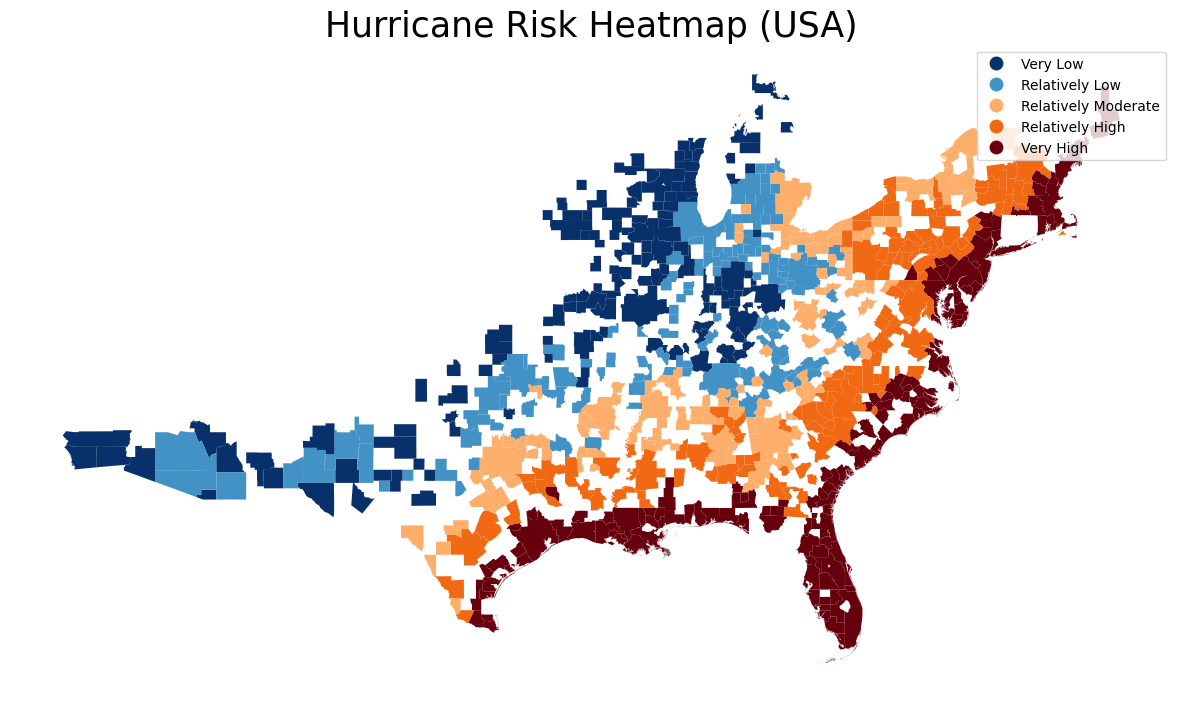

In [9]:
#5 bins based on quantiles to categorize the scores into 5 distinct sections
mainland_usa_gdf_msa_aggregated.loc[:,'HRCN_EALS_Norm'] = (mainland_usa_gdf_msa_aggregated['HRCN_EALS'] - mainland_usa_gdf_msa_aggregated['HRCN_EALS'].mean())/ mainland_usa_gdf_msa_aggregated['HRCN_EALS'].std()
mainland_usa_gdf_msa_aggregated.loc[:,'HRCN_RISK_CATEGORY_QUANTILE'] = pd.qcut(mainland_usa_gdf_msa_aggregated['HRCN_EALS_Norm'], q=5, labels=['Very Low', "Relatively Low", 'Relatively Moderate', 'Relatively High', 'Very High'])
colors = ['#08306b', '#4292c6', '#fdae6b', '#f16913', '#67000d']
custom_cmap = ListedColormap(colors)
#Plot the heatmap
fig, ax = plt.subplots(1, 1, figsize=(15, 25))
plt.grid(False)
mainland_usa_gdf_msa_aggregated.plot(column='HRCN_RISK_CATEGORY_QUANTILE', cmap=custom_cmap, linewidth=0.8, ax=ax, legend=True)
ax.set_title('Hurricane Risk Heatmap (USA)', fontdict={'fontsize': '25', 'fontweight' : '3'})
#Remove all axis values
ax.set_xticks([])
ax.set_yticks([])
#Remove all axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# Display the map
#Save plot heatmap
plt.savefig('../../Plots/hurricane_risk_heatmap_msa.png')
plt.show()

In [10]:
#extract MSA and geometry columns
geometry_key = mainland_usa_gdf_msa_aggregated[['MSA', 'geometry']]
#save geopandas dataframe to pickle
geometry_key.to_pickle('../../Data/geometry_key.pkl')

## Open connection SQL

In [11]:
db_path = "../../Database/thesis_database.db"
conn = sqlite3.connect(db_path)

### Transform dataset to necessary

In [12]:
mainland_usa_gdf_msa_aggregated_df = pd.DataFrame(mainland_usa_gdf_msa_aggregated.copy())

In [13]:
#remove all columns beside MSA, HRCN_EALS, HRCN_RISK_CATEGORY_QUANTILE, HRCN_AFREQ
mainland_usa_gdf_msa_aggregated_df = mainland_usa_gdf_msa_aggregated_df[['MSA', 'HRCN_EALS', 'HRCN_RISK_CATEGORY_QUANTILE', 'HRCN_AFREQ']]
# mainland_usa_gdf_msa_aggregated_df = mainland_usa_gdf_msa_aggregated_df.drop(columns=['geometry'])


In [14]:
mainland_usa_gdf_msa_aggregated_df.to_sql('hrcn_risk_agg', conn, if_exists = "replace", index = False)

669

## Close connection SQL

In [15]:
conn.close()